In [1]:
# Install necessary libraries
!pip install spacy sentence-transformers scikit-learn pdfminer.six python-docx matplotlib nltk

import os
import json
import docx
import spacy
from pdfminer.high_level import extract_text
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

# Load NLTK stopwords
import nltk
nltk.download('stopwords')

   ---------------------------------------- 0.0/5.6 MB ? eta -:--:--
   ---------------------------------------- 5.6/5.6 MB 48.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/203.0 MB ? eta -:--:--
   -- ------------------------------------- 10.5/203.0 MB 50.4 MB/s eta 0:00:04
   ------ --------------------------------- 31.5/203.0 MB 73.9 MB/s eta 0:00:03
   --------- ------------------------------ 47.4/203.0 MB 75.5 MB/s eta 0:00:03
   ------------- -------------------------- 66.3/203.0 MB 78.3 MB/s eta 0:00:02
   ---------------- ----------------------- 83.4/203.0 MB 79.4 MB/s eta 0:00:02
   ------------------- ------------------- 100.4/203.0 MB 79.1 MB/s eta 0:00:02
   ---------------------- ---------------- 117.4/203.0 MB 79.8 MB/s eta 0:00:02
   -------------------------- ------------ 138.4/203.0 MB 81.8 MB/s eta 0:00:01
   ------------------------------ -------- 157.3/203.0 MB 82.3 MB/s eta 0:00:01
   ---------------------------------- ---- 177.2/203.0 MB 83.9 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deepa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\deepa\.vscode\Anaconda\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\deepa\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [25]:
def preprocess_text(text):
    doc = nlp(text.lower())
    stop_words = set(stopwords.words("english"))
    # Focus on nouns, verbs, and named entities
    cleaned_text = [
        token.lemma_
        for token in doc
        if token.text not in stop_words and token.is_alpha and (token.pos_ in {"NOUN", "VERB"} or token.ent_type_)
    ]
    return " ".join(cleaned_text)

In [7]:
# Extract text from PDF
def extract_pdf_text(file_path):
    return extract_text(file_path)

# Extract text from DOCX
def extract_docx_text(file_path):
    doc = docx.Document(file_path)
    text = ""
    for para in doc.paragraphs:
        text += para.text + "\n"
    return text

In [9]:
def extract_section(text, section_name):
    # Define common section headers for resumes
    section_headers = {
        "skills": ["skills", "technical skills", "key skills"],
        "experience": ["experience", "work experience", "professional experience","project"],
        "education": ["education", "academic qualifications", "qualifications"]
    }

    # Identify section header
    section_start = None
    section_end = None

    lines = text.split("\n")
    for i, line in enumerate(lines):
        if any(header in line.lower() for header in section_headers.get(section_name, [])):
            section_start = i
            break

    if section_start is not None:
        # Look for the next header or end of text
        for j in range(section_start + 1, len(lines)):
            if any(header in lines[j].lower() for header in section_headers.values()):
                section_end = j
                break

    # Extract section content
    if section_start is not None:
        if section_end is None:
            section_end = len(lines)
        return " ".join(lines[section_start:section_end])

    return None  # Section not found


In [11]:
def compute_sectional_similarity(resume_text, job_desc_text):
    sections = ["skills", "experience", "education"]
    scores = {}

    for section in sections:
        # Extract relevant section text (implement extraction logic as needed)
        resume_section = extract_section(resume_text, section)
        job_desc_section = extract_section(job_desc_text, section)
        if resume_section and job_desc_section:
            scores[section] = compute_semantic_similarity(resume_section, job_desc_section)

    # Weighted average based on section importance
    weighted_score = (
        scores.get("skills", 0) * 0.4 +
        scores.get("experience", 0) * 0.4 +
        scores.get("education", 0) * 0.2
    )
    return weighted_score, scores

In [13]:
def compute_semantic_similarity(text1, text2):
    # Generate embeddings
    embedding1 = sbert_model.encode(text1, convert_to_tensor=True)
    embedding2 = sbert_model.encode(text2, convert_to_tensor=True)
    # Compute cosine similarity
    similarity_score = util.pytorch_cos_sim(embedding1, embedding2)
    return similarity_score.item()

In [15]:
def extract_important_keywords(text, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([text])
    keywords = sorted(
        zip(vectorizer.get_feature_names_out(), tfidf_matrix.toarray()[0]),
        key=lambda x: x[1], reverse=True
    )[:top_n]
    return [keyword for keyword, score in keywords]

In [29]:
# Generate feedback based on keywords
def generate_detailed_feedback(resume_keywords, job_desc_keywords):
    matched = set(resume_keywords) & set(job_desc_keywords)
    missing = set(job_desc_keywords) - set(resume_keywords)

    missing_counter = Counter(missing)

    # Prioritize top missing keywords
    top_missing = [word for word, _ in missing_counter.most_common(10)]

    return {
        "Matched Skills": list(matched),
        "Missing Skills": list(top_missing),
        "Suggestions": [f"Consider adding '{skill}' to your resume." for skill in top_missing]
    }


In [37]:
# Visualize similarity score
def visualize_sectional_scores(similarity_score):
    labels = ['Matched', 'Unmatched']
    sizes = [similarity_score * 100, 100 - similarity_score * 100]
    colors = ['#4CAF50', '#FF6347']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title("Resume Matching Score")
    plt.show()

In [21]:
def check_resume_match(resume_file, job_desc_text):
    # Extract text from resume
    if resume_file.lower().endswith('.pdf'):
        resume_text = extract_pdf_text(resume_file)
    elif resume_file.lower().endswith('.docx'):
        resume_text = extract_docx_text(resume_file)
    else:
        raise ValueError("Unsupported file format. Use PDF or DOCX.")

    # Preprocess texts
    processed_resume = preprocess_text(resume_text)
    processed_job_desc = preprocess_text(job_desc_text)

    # Check for empty processed text
    if processed_resume == "empty" or processed_job_desc == "empty":
        raise ValueError("Processed text is empty; ensure input documents contain meaningful content.")

    # Compute similarity
    similarity_score = compute_semantic_similarity(processed_resume, processed_job_desc)

    # Extract keywords for feedback
    resume_keywords = processed_resume.split()
    job_desc_keywords = processed_job_desc.split()

    feedback = generate_detailed_feedback(resume_keywords, job_desc_keywords)

    # Display similarity and feedback
    print(f"Similarity Score: {similarity_score * 100:.2f}%")
    print("\nFeedback:")
    print(json.dumps(feedback, indent=4))

    # Visualize the score
    visualize_sectional_scores(similarity_score)

    return similarity_score, feedback


Similarity Score: 70.91%

Feedback:
{
    "Matched Skills": [
        "experience",
        "python",
        "base",
        "solution",
        "understanding",
        "enhance",
        "include",
        "technology",
        "science",
        "professional",
        "result",
        "goal",
        "standard",
        "contribute",
        "project",
        "communication",
        "objective",
        "work",
        "need",
        "collaborate",
        "provide",
        "management",
        "visualization",
        "tableau",
        "develop",
        "knowledge",
        "promote",
        "product",
        "planning",
        "dataset",
        "industry",
        "business",
        "outcome",
        "program",
        "certificate",
        "information",
        "education",
        "sql",
        "skill",
        "level",
        "model",
        "machine",
        "data",
        "development",
        "technique",
        "create",
        "tool",
        "ana

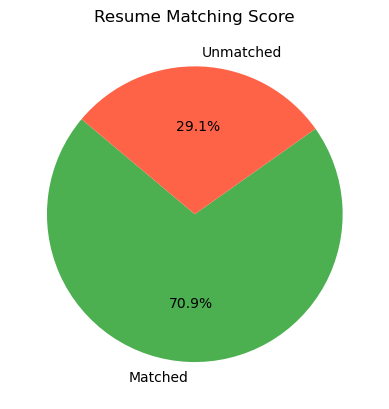

In [39]:
# Example job description
job_desc_text = """About the job
Joining Arup

At Arup we’re dedicated to sustainable development and to do socially useful work that has meaning.Our purpose, shared values and collaborative approach has set us apart for over 75 years, guiding how we shape a better world.

We solve the world's most complex problems and deliver what seems impossible, with curiosity and creativity. We’re a thriving and growing organisation which offers you many possibilities to shape a better world, and your future.

Our growing Digital Advisory, Software Development, Data, Geospatial team in Toronto, Ontario, Canada is seeking to recruit a Data Scientist / Analyst to join us. Our regional team is made up of a global group of geospatial professionals, software developers and digital consultants within Arup. We use our collective talents to incubate and deliver technology-led solutions to clients, and in doing so help transform the way that cities, buildings and physical networks are planned and delivered, to ensure a better world for all.

 The opportunity

At Arup, you belong to an extraordinary collective – in which we encourage individuality to thrive. Our strength comes from how we respect, share and connect our diverse experiences, perspectives and ideas.

You will have the opportunity do socially useful work that has meaning – to Arup, to your career, to our members and to the clients and communities we serve.

Working as part of a growing team in Canada, and as the first Digital team member located in our Toronto office, you will be leading and/or delivering technical digital solutions related to environmental, planning and infrastructure aspects of local, national and international projects. You will work as part of a diverse, digitally minded team on projects of various types and scales, regularly cross-collaborating with other multi-disciplinary Arup teams and working closely with our clients to advise and to help shape a better world, one project at a time.

 Is this role right for you?

Education and skills
 Undergraduate Degree or Certificate / Diploma in Data or Information Sciences, Artificial Intelligence (AI), Machine Learning (ML), Deep Learning (DL), GIS, Computer Science, Full-Stack Software Development, Engineering, Information Technology or similar digital discipline with a focus on data.
 At least three or more (3+) years of experience in providing data analytical techniques and automation solutions to business
 Solid experience with database architecture including defining data standards, database design and integration with proprietary project systems
 Experience working in SQL with experience in relational databases such as MS SQL Server, MySQL, PostgreSQL, or OracleProficiency with analytic tools such as Python, R and/or FME for data analysis, data engineering and automation tasks

Experience
Experience creating automated data workflows using commercial-off-the-shelf / low-code / no-code options such as Power Automates or scripting


 Ability to synthesize complex datasets and transform into visualizations using tools such as PowerBI, Tableau or other out of the box technology.
 Experience in requirements gathering, business process modeling and translating business needs into technical solutions, and ensuring alignment with overall project objectives.
 Awareness / basic knowledge of emerging technologies such as machine learning, AI and/or deep learning to enhance data processes
 Strong communication skills with the ability to engage with both technical and non-technical stakeholders
 Enjoys working as part of and actively contributing to a positive, inclusive, and supportive team culture.


Preferred Qualifications

The below qualifications are not mandatory, but are considered an asset:


 Master’s Degree or Advanced Certificate / Diploma in Degree or Post-Graduate Certificate / Diploma in Data or Information Sciences, Artificial Intelligence (AI), Machine Learning (ML), Deep Learning (DL), GIS, Computer Science, Full-Stack Software Development, Engineering, Information Technology or similar digital discipline with a focus on data.
 Experience working with / knowledge of data and information and document management server technologies such as AutoDesk Construction Cloud, ArcGIS Enterprise, ProjectWise, SharePoint, Aconex, Unifier, Asite among others.
 Experience working in compliance with data governance, data privacy regulations, and industry standards including application of ISO standards
 Good working knowledge or experience in Agile concepts to support the successful delivery of digital projects.
 Experience working with cloud technologies such as Azure, AWS, DataBricks
 Applied experience with / ability to leverage machine learning, AI and/or deep learning to enhance data processes
 Experience with scoping, planning and delivery of Proof-of-Concept (POC) and/or Minimum Viable Product (MVP) for research and development or conceptual test use cases.
 Working proficiency in reading, writing and speaking in both of Canada’s official languages – English and French.


Please note that all applicants must apply directly via the job portal. If this role is not quite what you are looking for but you are interested in other opportunities for a future with purpose, please sign up to our Talent Community is where you will be kept up to date with roles suitable for you to shape a better world.

What We Offer You

At Arup, we care about each member’s success, so we can grow together.

Guided by our values, we provide an attractive total reward package that recognizes the contribution of each of our members to our shared success. As well as competitive, fair and equitable pay, we offer a career in which all of our members can belong, grow and thrive – through benefits that support health and wellbeing, a wide range of learning opportunities and many possibilities to have an impact through the work they do.

We are owned in trust on behalf of our members, giving us the freedom, with personal responsibility, to set our own direction and choose work that aligns with our purpose and adds to Arup’s legacy. Our members collaborate on ambitious projects to deliver remarkable outcomes for our clients and communities. Profit Share is a key part of our reward, enabling members to share in the results of our collective efforts.

Benefits that Work - At Arup, we have a comprehensive and valuable benefits program that works for our employees and their families. These are 100% paid for by Arup except for optional life insurance. These benefits provide health and welfare security for you as well as paid time off for rest and renewal. Our Global Profit Share Plan (paid bi-annually) provides an opportunity for you to share in the success of the Firm. As a valued employee of Arup, you can also choose to participate in our GRRSP 5% company match to help you save for your future.

Hiring Range - The good faith base salary hiring range for this job if performed in Toronto is $66,100 to $90,200 per year. This range is commensurate with experience, educational background, and skill level. Benefits are not included in the base salary. Please note hiring ranges for candidates performing work outside of Toronto will differ.

Flexible Working - We believe that flexible arrangements create a more inclusive way of working that supports our diversity and the wellbeing of our people. Options for alternative schedules and the ability to work outside of the office for a portion of your workweek are available.

 Different people, shared values

Arup is an equal opportunity employer that actively promotes and nurtures a diverse and inclusive workforce. We welcome applications from individuals of all backgrounds, regardless of age (within legal limits), gender identity or expression, marital status, disability, neurotype or mental health, race or ethnicity, faith or belief, sexual orientation, socioeconomic background, and whether you’re pregnant or on family leave. We are an open environment that embraces diverse experiences, perspectives, and ideas – this drives our excellence.

Guided by our values and alignment with the UN Sustainable Development Goals, we create and contribute to equitable spaces and systems, while cultivating a sense of belonging for all. Our internal employee networks support our inclusive culture: from race, ethnicity and cross-cultural working to gender equity and LGBTQ+ and disability inclusion – we aim to create a space for you to express yourself and make a positive difference. Discover more about life at Arup at www.arup.com/careers/your-life-at-arup.

Our internal employee networks support our inclusive culture – from race, ethnicity and cross-cultural working to gender, LGBTQ+ and disability – we aim to create a space for you to express yourself and make a positive difference - Discover more about life at Arup at www.arup.com/careers/your-life-at-arup .

Our Toronto office is located on ceded and unceded lands of many nations including the Mississaugas of the Credit, the Anishinabewaki, and the Haudenosaunee (hoe-dee-no-SHOW-nee). We acknowledge this land and its people to build a shared understanding of how our collective past brings us to where we are today. Through our ever-developing commitments, we strive to strengthen our relationships with this land, its people, and its treaties to shape a better, more inclusive world.
"""

# Example resume file
resume_file = "Deepanshu_Gupta_resume.pdf"  # Replace with your file path

# Run the match
similarity_score, feedback = check_resume_match(resume_file, job_desc_text)